In [72]:
using Gen
using Random
using CairoMakie

#### Helper functions

In [73]:
const Card = Union{Symbol, Int}
const State = Tuple{Int, Card, Bool}

CARD_MAP = [:ace, :two, :three, :four, :five, :six, :seven, :eight, :nine, :ten, :jack, :queen, :king]

function sort_hand(hand)
    # aces should be last
    return sort(hand, lt=(x,y) -> x != :ace)
end

function get_value(card, sum_so_far)
    if card == :ace
        if sum_so_far + 11 <= 21
            return 11
        else
            return 1
        end
    elseif card == :jack || card == :queen || card == :king
        return 10
    else
        # get index in card map
        return findfirst(x -> x == card, CARD_MAP)
    end
end

function get_sum(hand)
    hand = sort_hand(hand)
    sum = 0
    for card in hand
        sum += get_value(card, sum)
    end
    return sum
end

function holds_usable_ace(hand)
    hand = sort_hand(hand)
    sum = 0
    for card in hand
        value = get_value(card, sum)    
        if value == 11
            return true
        end
        sum += value
    end
    return false
end

function states()
    states = []
    for i in 4:21
        for j in 1:13
            for k in [true, false]
                push!(states, (i, CARD_MAP[j], k))
            end
        end
    end
    return states
end

STATES = states();

using CairoMakie
using IJulia  # For clearing output in Jupyter notebooks

function plot_choices(trace)
    choices = get_choices(trace)
    
    # Define ranges for player sums and dealer showing cards
    player_sums = 12:21  # x-axis
    dealer_showing = 1:13  # y-axis

    # Create observable variables for z-values (initially zero)
    z_true = Observable(zeros(Float64, length(player_sums), length(dealer_showing)))
    z_false = Observable(zeros(Float64, length(player_sums), length(dealer_showing)))

    # Create figure
    fig = Figure(resolution = (800, 600))

    # Surface plot with usable ace
    ax1 = Axis3(fig[1, 1], title = "Usable Ace")
    surface!(ax1, player_sums, dealer_showing, z_true)
    ax1.xlabel = "Player sum"
    ax1.ylabel = "Dealer showing"
    ax1.zlabel = "1 = Hit, 0 = Stick"

    # Surface plot without usable ace
    ax2 = Axis3(fig[1, 2], title = "No Usable Ace")
    surface!(ax2, player_sums, dealer_showing, z_false)
    ax2.xlabel = "Player sum"
    ax2.ylabel = "Dealer showing"
    ax2.zlabel = "1 = Hit, 0 = Stick"

    # Function to update the observables with new trace data
    function update_plot(trace)
        
        new_choices = get_choices(trace)

        new_z_true = zeros(Float64, length(player_sums), length(dealer_showing))
        new_z_false = zeros(Float64, length(player_sums), length(dealer_showing))

        for i in player_sums
            for j in dealer_showing
                card = CARD_MAP[j]
                new_z_true[i - 11, j] = new_choices[(:policy, i, card, true)]
                new_z_false[i - 11, j] = new_choices[(:policy, i, card, false)]
            end
        end

        # Update the observables with new values
        z_true[] = new_z_true
        z_false[] = new_z_false

        # Clear the old output in the notebook and display the new plot
        IJulia.clear_output(true)  # Clear the old output in the current cell
        display(fig)  # Display the updated figure
    end

    # Display the figure for the first time
    display(fig)

    return update_plot  # Return the function that updates the plot
end;


#### Helper distributions

In [74]:
@dist function draw_card()
    card = uniform_discrete(1,13)
    CARD_MAP[card]
end;

#### Model

In [160]:
@gen function simplejack_model(policy :: Dict{Int, Float64})
    # the goal of simplejack is to draw cards and get as close to 21 as possible without going over
    
    sum = 0
    hand = []

    # Player's turn
    for t in 1:5
        if sum > 21
            action = {:a => t} ~ bernoulli(0)
        else
            action = {:a => t} ~ bernoulli(policy[sum])
        end
        if action == 1
            card = {:card => t} ~ draw_card()
            push!(hand, card)
            sum = get_sum(hand)
        end
    end

    if sum > 21
        ret = 0
    else
        ret = exp(sum-21)
    end

    return ret
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Dict{Int64, Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##simplejack_model#248", Bool[0], false)

In [168]:
@gen function simplejack_model2(policy :: Dict{Int, Float64})
    # the goal of simplejack is to draw cards and get as close to 21 as possible without going over
    
    sum = 0
    hand = []

    # Player's turn
    for t in 1:5
        if sum > 21
            action = bernoulli(0)
        else
            action = bernoulli(policy[sum])
        end
        if action == 1
            card = draw_card()
            push!(hand, card)
            sum = get_sum(hand)
        end
    end

    if sum > 21
        ret = 0
    else
        ret = exp(sum-21)
    end

    return ret
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Dict{Int64, Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##simplejack_model2#250", Bool[0], false)

In [187]:
@gen function policy_search()
    policy = Dict{Int64, Float64}()
    for i in 0:21
        policy[i] = {:p => i} ~ uniform(0,1)
    end

    ret = {:r} ~ simplejack_model2(policy)

    o ~ bernoulli(ret)

    return policy, ret
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##policy_search#252", Bool[], false)

In [188]:
trace = simulate(policy_search,())
get_choices(trace)

│
├── :o : false
│
├── :r
│
└── :p
    │
    ├── 5 : 0.3990208213868699
    │
    ├── 16 : 0.524415670386224
    │
    ├── 20 : 0.820850955090983
    │
    ├── 12 : 0.1567159699163827
    │
    ├── 8 : 0.7479796628354978
    │
    ├── 17 : 0.6562329828381337
    │
    ├── 1 : 0.4358604881180226
    │
    ├── 19 : 0.7755706687457582
    │
    ├── 0 : 0.2847725160489173
    │
    ├── 6 : 0.1516375072151953
    │
    ├── 11 : 0.21650855672256786
    │
    ├── 9 : 0.6368120484582463
    │
    ├── 14 : 0.25606850941944503
    │
    ├── 3 : 0.012847278322923206
    │
    ├── 7 : 0.048145649880471875
    │
    ├── 4 : 0.14990938120674568
    │
    ├── 13 : 0.6400031172033843
    │
    ├── 15 : 0.33759205579035034
    │
    ├── 2 : 0.7520622049327316
    │
    ├── 10 : 0.969540351588878
    │
    ├── 18 : 0.750747424019463
    │
    └── 21 : 0.41252036638792156


In [211]:
function block_update(trace)
    # update policy
    for i in 0:21
        (trace,_) = mh(trace,select(:p => i))
    end
    return trace
end
    

block_update (generic function with 1 method)

In [228]:
(trace,_) = generate(policy_search,(), choicemap((:o, 1)))
println(trace[:r])
(new_trace,acc) = mh(trace, select(:p => 0))
println(acc, new_trace[:r])

1.0
true0.36787944117144233


In [212]:
(trace,_) = generate(policy_search,(), choicemap((:o, 1)))
traces = [trace]
for i in 1:1e3
    trace = block_update(trace)
    push!(traces, trace)
end

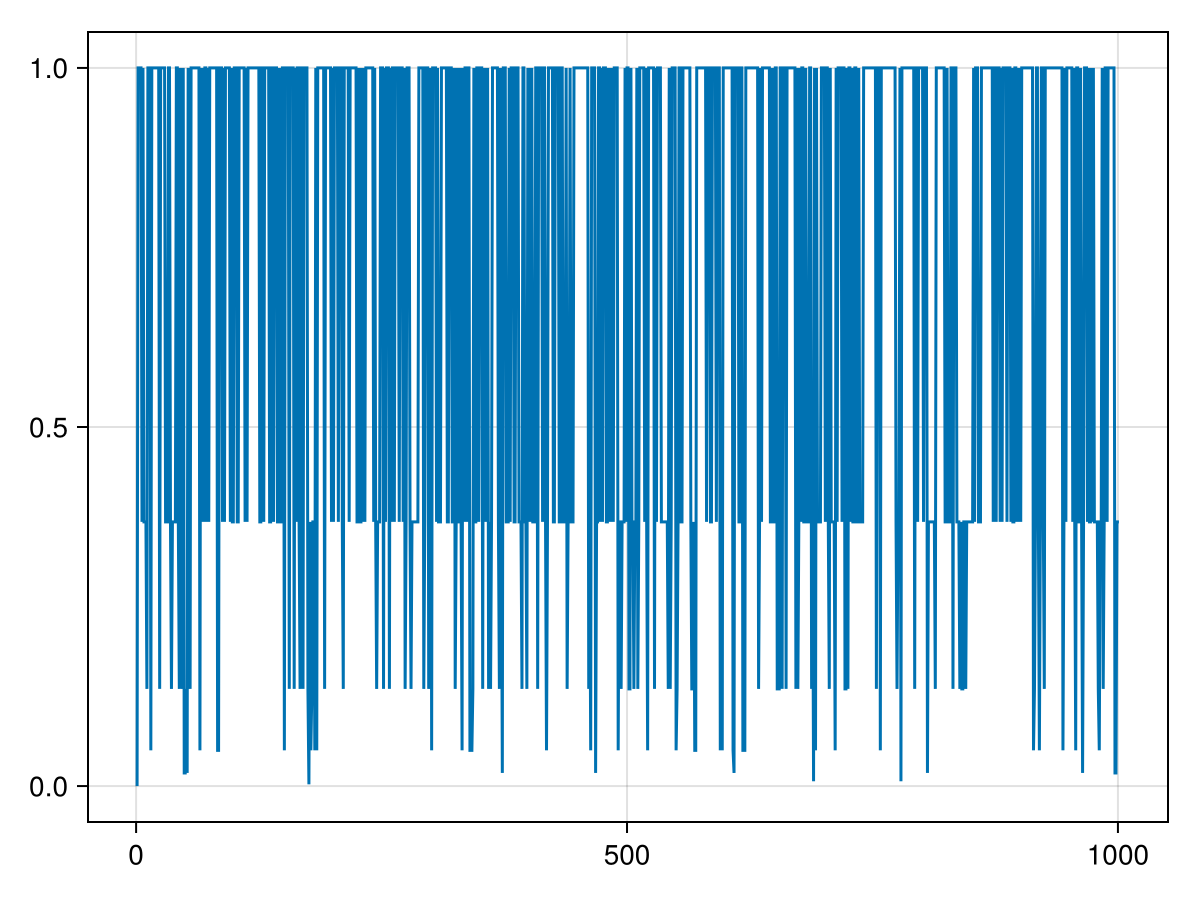

In [213]:
lines([t[:r] for t in traces])

In [57]:
@gen function blackjack_model(eps)
    sum = 0
    
    # initialize policy
    policy = Dict{State, Float64}()
    for state in STATES
        policy[state] = {(:policy, state...)} ~ beta(1,1) #prior
    end

    # Player
    card1 ~ draw_card()
    card2 ~ draw_card()
    hand = [card1, card2]

    # Dealer
    dealer_first_card ~ draw_card()
    dealer_visible_card ~ draw_card()

    sum = get_sum(hand)
    state = (sum, dealer_visible_card, holds_usable_ace(hand))

    # Player's turn
    for i in 3:11 
        action = {(:q, state...)} ~ bernoulli(policy[state])
        if action == 1
            card = {(:card, i)} ~ draw_card()
            push!(hand, card)
            sum = get_sum(hand)
            state = (sum, dealer_visible_card, holds_usable_ace(hand))
            if sum > 21
                break
            end
        else
            break
        end
    end

    # Dealer's turn
    dealer_hand = [dealer_first_card, dealer_visible_card]
    dealer_sum = get_sum(dealer_hand)
    while dealer_sum < 17
        card = {(:dealer_card, dealer_sum)} ~ draw_card()
        push!(dealer_hand, card)
        dealer_sum = get_sum(dealer_hand)
    end

    ret = 0
    
    # Determine winner
    if sum > 21
        ret ={:return} ~ normal(-1, eps)
    elseif dealer_sum > 21
        ret ={:return} ~ normal(1, eps)
    elseif sum > dealer_sum
        ret ={:return} ~ normal(1, eps)
    elseif sum < dealer_sum
        ret ={:return} ~ normal(-1, eps)
    else
        ret ={:return} ~ normal(0, eps)
    end


    return state, hand, dealer_sum, ret
end;

In [58]:
trace = simulate(blackjack_model, (0.1,))
println(get_retval(trace))

((18, :two, false), [:nine, :nine], 19, -0.8946800738960508)


In [59]:
condition = choicemap()
condition[(:return)] = 1
(trace, logprob) = generate(blackjack_model, (0.1,), condition)
choices = get_choices(trace)



│
├── (:policy, 4, :king, true) : 0.23833612259851342
│
├── (:policy, 13, :three, true) : 0.8385813391972533
│
├── (:policy, 21, :five, true) : 0.9538908893586255
│
├── (:policy, 8, :eight, true) : 0.7338868003604382
│
├── (:policy, 13, :three, false) : 0.7194539282859419
│
├── (:policy, 5, :two, false) : 0.3727816003805957
│
├── (:policy, 7, :four, true) : 0.5773427351169084
│
├── (:policy, 21, :ten, false) : 0.4486361673009915
│
├── (:policy, 10, :eight, false) : 0.30403013443331883
│
├── (:policy, 20, :ten, true) : 0.028540926226659123
│
├── (:policy, 16, :ten, false) : 0.8893006897410342
│
├── (:policy, 8, :ace, false) : 0.8499992884294257
│
├── (:policy, 19, :seven, false) : 0.786797071954851
│
├── (:policy, 19, :queen, true) : 0.5278320986397599
│
├── (:policy, 19, :jack, false) : 0.8554556343310815
│
├── :dealer_visible_card : five
│
├── (:policy, 12, :eight, false) : 0.705721385820534
│
├── (:policy, 4, :eight, true) : 0.7111912570689277
│
├── (:policy, 11, :four, false) : 0.63

In [60]:
trace[:return]

1.0

In [61]:
choices[(:policy, 4, :ace, true)]

0.8928926172522051

### MCMC

In [62]:
function block_update(trace)
    for state in STATES
        (trace, _) = mh(trace, select((:policy, state...)))
    end
    return trace
end



@gen function proposal(curr_trace, state, kappa)
    curr_val = curr_trace[(:policy, state...)]
    α = curr_val * kappa
    β = (1 - curr_val) * kappa
    {(:policy, state...)} ~ beta(α, β)
end


function drift_update(trace, max_rep)
    for state in STATES
        accept = false
        while !accept && max_rep > 0
            (trace, accept) = mh(trace, proposal, (state, 1))
            max_rep -= 1
        end
    end
    return trace
end;

In [63]:
function mcmc(trace, n_iter, update_plot)
    traces = [trace]
    for i in 1:n_iter
        trace = drift_update(trace, 100)
        update_plot(trace)
        push!(traces, trace)
    end
    return traces
end;

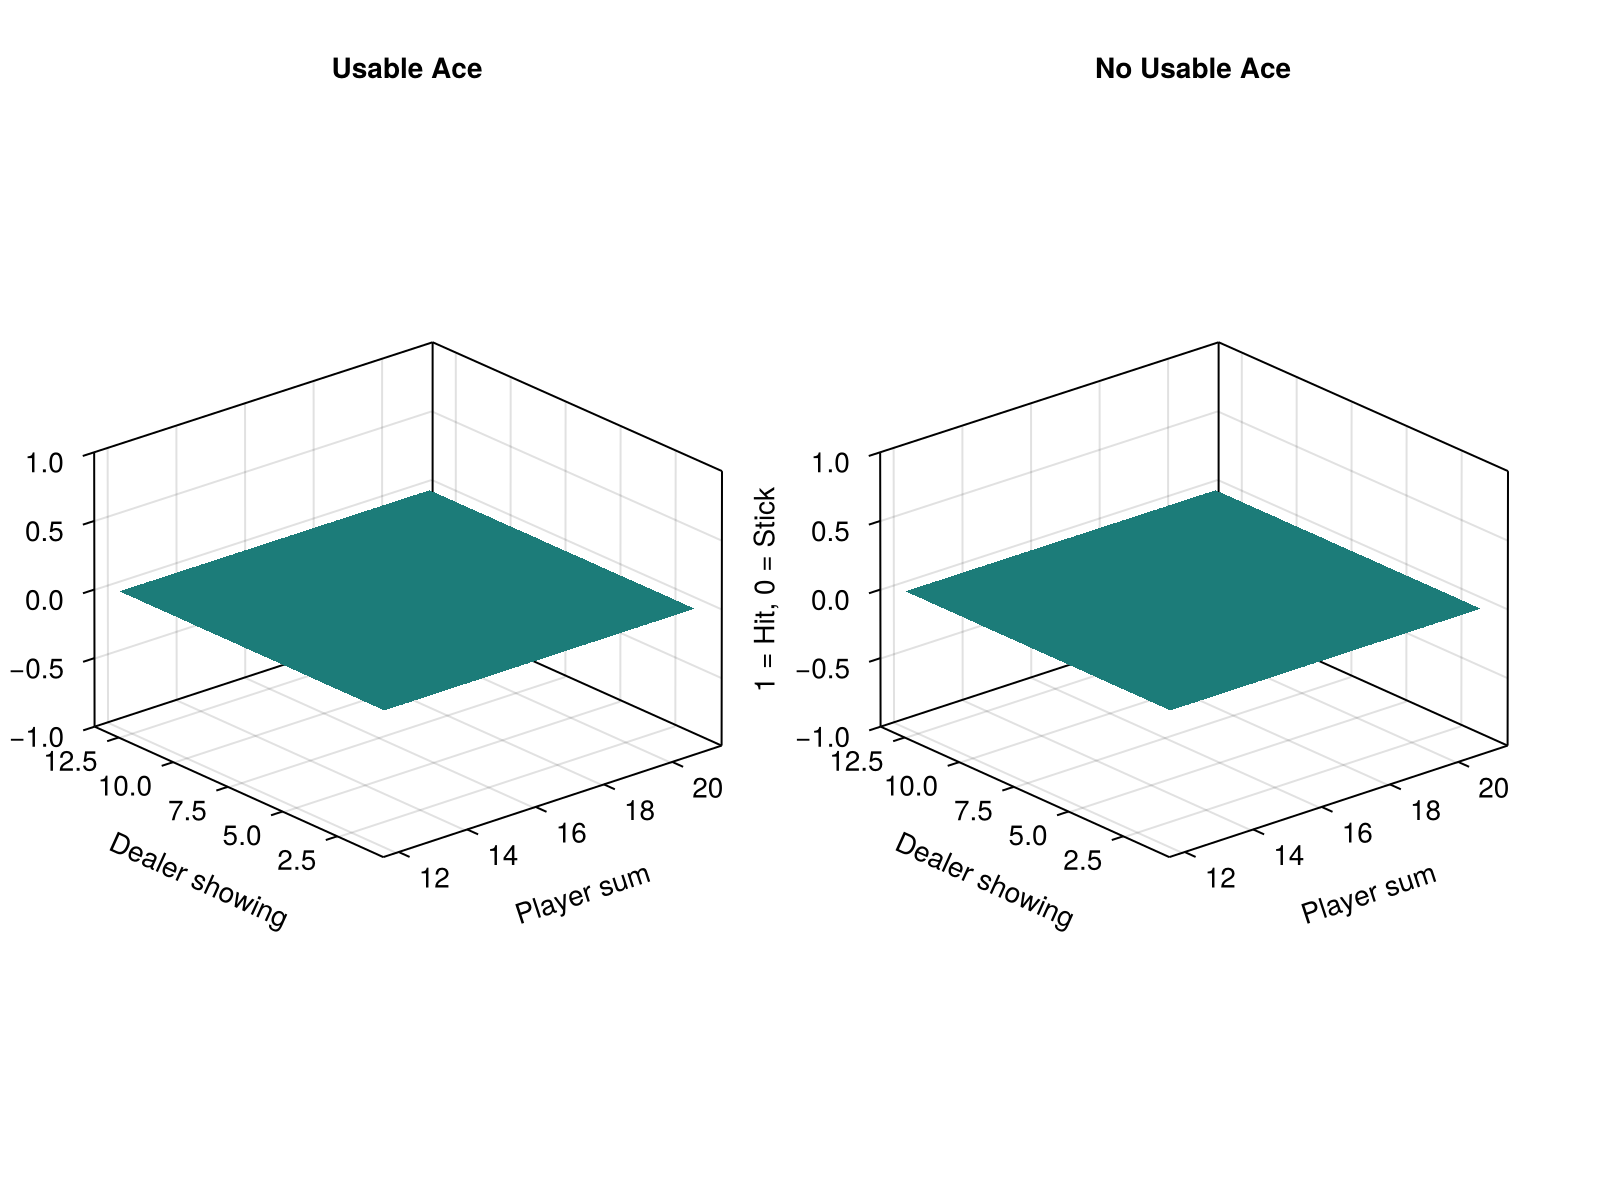

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/mariusfurter/.julia/packages/Makie/eziUH/src/scenes.jl:227


UndefRefError: UndefRefError: access to undefined reference

In [64]:
Random.seed!(1234)
condition = choicemap()
condition[(:return)] = 1
(trace, logprob) = generate(blackjack_model, (0.1,), condition)
update_plot = plot_choices(trace)
traces = mcmc(trace, 10, update_plot);